# Advanced Regression

Regression models continuous-valued functions, i.e. it is used to predict missing or unavailable numerical data values rather than class labels. The inputs for regression can be real values or discrete input variables. When there are multiple input variables, it is known as a multivariate regression problem. When the input variables are ordered by time, it is known as a time series forecasting problem.

In this notebook, we use a data set from NASA: Turbofan Engine Degradation Simulation 9https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/). This is a multiple multivariate time series data set consisting of sensor readings from a fleet of simulated aircraft gas turbine engines. Our goal is to predict the remaining useful life of the engine units.

We will first do some exploratory data analysis, then prepare our data for modelling, then finally run some regression models for comparison. We will use three different algorithms: a neural network, a kernel ridge regression, and a random forest regression.


# Load dependencies

First, we will load the dependencies for this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_selection import RFE
from sklearn import metrics
from scipy.stats import pearsonr
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
pd.set_option('max_columns', 30)
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score

%matplotlib inline

# Load data

We will now load the data required for this notebook. As mentioned, the data comes from the NASA Turbofan data sets. We have three different data sets: a training set, a testing set, and unsesson values for remaining useful life (RUL).

In [28]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_9a1c599639334c4db6a099ac66965340 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='<redacted>',
    ibm_auth_endpoint="<redacted>",
    config=Config(signature_version='oauth'),
    endpoint_url='<redacted>')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_4 = client_9a1c599639334c4db6a099ac66965340.get_object(Bucket='<redacted>', Key='train_FD001.txt')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_4, "__iter__"): streaming_body_4.__iter__ = types.MethodType( __iter__, streaming_body_4 ) 


In [33]:

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_5 = client_9a1c599639334c4db6a099ac66965340.get_object(Bucket='<redacted>', Key='test_FD001.txt')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_5, "__iter__"): streaming_body_5.__iter__ = types.MethodType( __iter__, streaming_body_5 )


In [34]:

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_6 = client_9a1c599639334c4db6a099ac66965340.get_object(Bucket='<redacted>', Key='RUL_FD001.txt')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_6, "__iter__"): streaming_body_6.__iter__ = types.MethodType( __iter__, streaming_body_6 ) 


# Exploratory Data Analysis

Before we get started with modelling, we need to get the data ready. Typically the first step is to take a closer look at the data set's features and associated values. Often, data is noisy, comes in large volumes, and may come from many different sources. Therefore, you need to understand your data before you can start preprocessing it. Some of the questions you will want to answer are:

* What are the types of features in the data set?
* What kind of values does each feature have?
* Which features are discrete, and which are continuous-valued?
* How are the values distributed in each feature?
* Can we better understand the data through visualization?
* Are there any outliers?
* How similar are some data points to others?

First, let's get the dimensions of the training data set. We can see that the data set has 20631 rows and 28 features or attributes.

In [5]:

exp_data = pd.read_csv(streaming_body_4, sep = ' ', header = None)

In [6]:
exp_data.shape

(20631, 28)

The last two columns have NaN data, so we can remove those. We can also see that the first column is the unit and the second is the cycle. Let's rename the columns accordingly. 


In [7]:
exp_data = exp_data[list(range(0, 26))]
exp_data.rename(columns = {0 : 'unit', 1 : 'cycle', 2 : 'op_setting1', 3 : 'op_setting2', 4 : 'op_setting3', 5 : 's1', 6 : 's2', 7 : 's3', 8 :'s4', 9 : 's5', 10 : 's6', 11 : 's7', 12 : 's8', 13 : 's9', 14 : 's10', 15 : 's11', 16 : 's12', 17 : 's13', 18 : 's14', 19 : 's15', 20 : 's16', 21 : 's17', 22 : 's18', 23 : 's19', 24 : 's20', 25 : 's21'}, inplace = True)
exp_data.head()

,unit,cycle,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Let's see some aggregated statistics for the data set.

In [8]:
exp_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


Now, let's assign the number max number cycles for each unit and the remaining useful per time stamp.

In [9]:
total_cycles = exp_data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
exp_data = exp_data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
exp_data['RUL'] = exp_data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)

In [10]:
exp_data.head()

,unit,cycle,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,total_cycles,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


Let's examine the maximum number of cycles for each unit in the data set. It looks like most units last over 100 cycles.

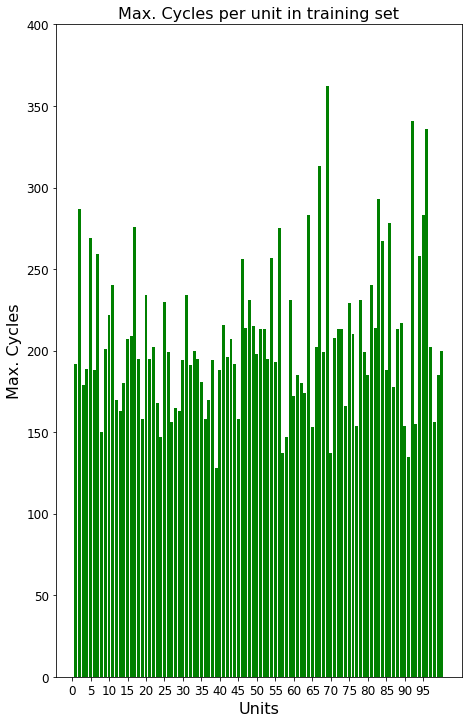

In [11]:
fig = plt.figure(figsize = (16,12))
fig.add_subplot(1,2,1)
bar_labels = list(exp_data['unit'])
bars = plt.bar(list(exp_data['unit']), exp_data['cycle'], color='green')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in training set', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Visualization of operating conditions and sensors

The following visualizes the operating conditions and some of different sensors of a particular unit. It shows that the sensors often different range of values and show differing patterns and trends over time i.e. some increasing, some flat, and some decreasing. 

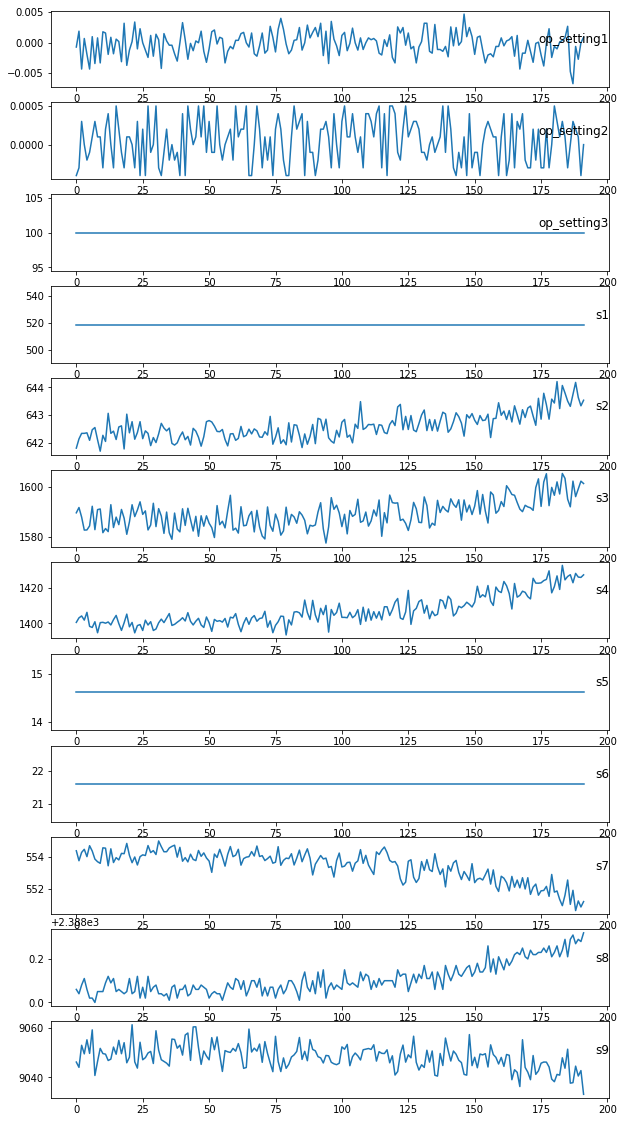

In [12]:
values = exp_data[exp_data.unit==1].values
groups = [2,3, 4, 5, 6, 7, 8, 9, 10, 11,12,13]
i = 1
plt.figure(figsize=(10,20))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(exp_data.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Let's display what a single sensor looks for multiple engine units. We can see that it increases over time towards a max of 2388.20 and the data looks quite noisy. 

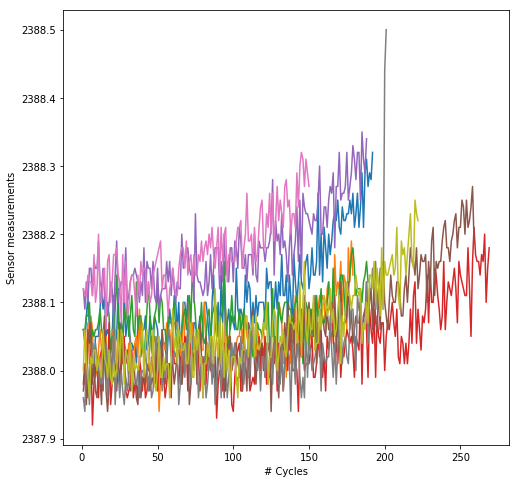

In [13]:
plt.figure(figsize = (8, 8))
plt.plot(exp_data[exp_data.unit==1].cycle, exp_data[exp_data.unit==1].s8)
plt.plot(exp_data[exp_data.unit==3].cycle, exp_data[exp_data.unit==3].s8)
plt.plot(exp_data[exp_data.unit==4].cycle, exp_data[exp_data.unit==4].s8)
plt.plot(exp_data[exp_data.unit==5].cycle, exp_data[exp_data.unit==5].s8)
plt.plot(exp_data[exp_data.unit==6].cycle, exp_data[exp_data.unit==6].s8)
plt.plot(exp_data[exp_data.unit==7].cycle, exp_data[exp_data.unit==7].s8)
plt.plot(exp_data[exp_data.unit==8].cycle, exp_data[exp_data.unit==8].s8)
plt.plot(exp_data[exp_data.unit==9].cycle, exp_data[exp_data.unit==9].s8)
plt.plot(exp_data[exp_data.unit==10].cycle, exp_data[exp_data.unit==10].s8)
plt.xlabel('# Cycles')
plt.ylabel('Sensor measurements')
plt.show()

You might expect that sensors exhibit similar min and max values, even for different units. Let's see if we can confirm that with some data visualization.

In [14]:
minb = exp_data.groupby('unit', as_index=False).min().head(10)
maxb = exp_data.groupby('unit', as_index=False).max().head(10)
mmtable = minb.append(maxb, ignore_index=True)

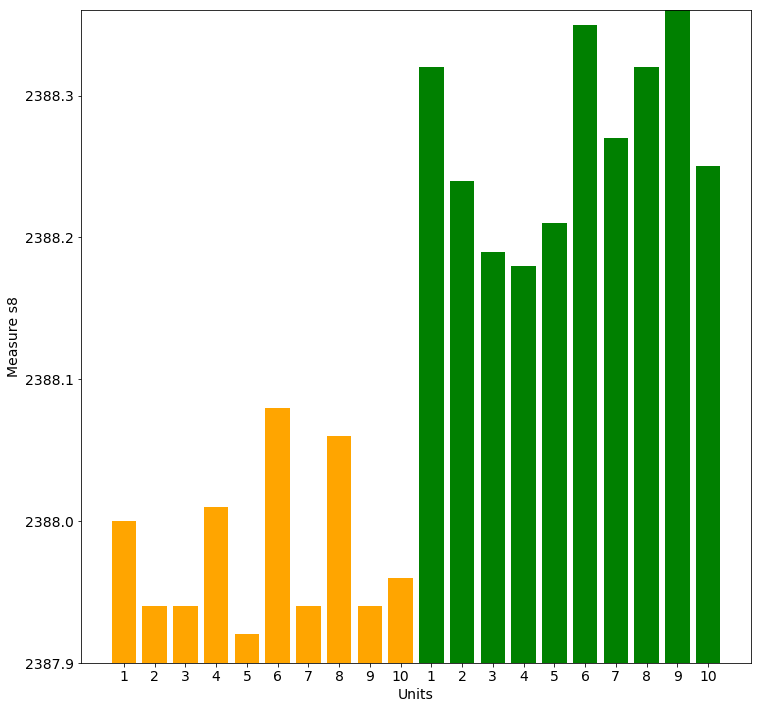

In [15]:
plt.figure(figsize = (12,12))
col = np.concatenate((np.repeat('orange', 10), np.repeat('green', 10)), axis=0)
bar_labels = list(mmtable['unit'])
x_pos = list(range(len(bar_labels)))
bars = plt.bar(x_pos, mmtable['s8'], color=col)
plt.ylim([2387.90, 2388.36])
plt.xlabel('Units', fontsize=14)
plt.ylabel('Measure s8', fontsize=14)
plt.xticks(x_pos, bar_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Let's look at how our data set is looking now with these new features.

In [16]:
exp_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


We'll now generate some histograms to demonstrate the range of values per sensor.

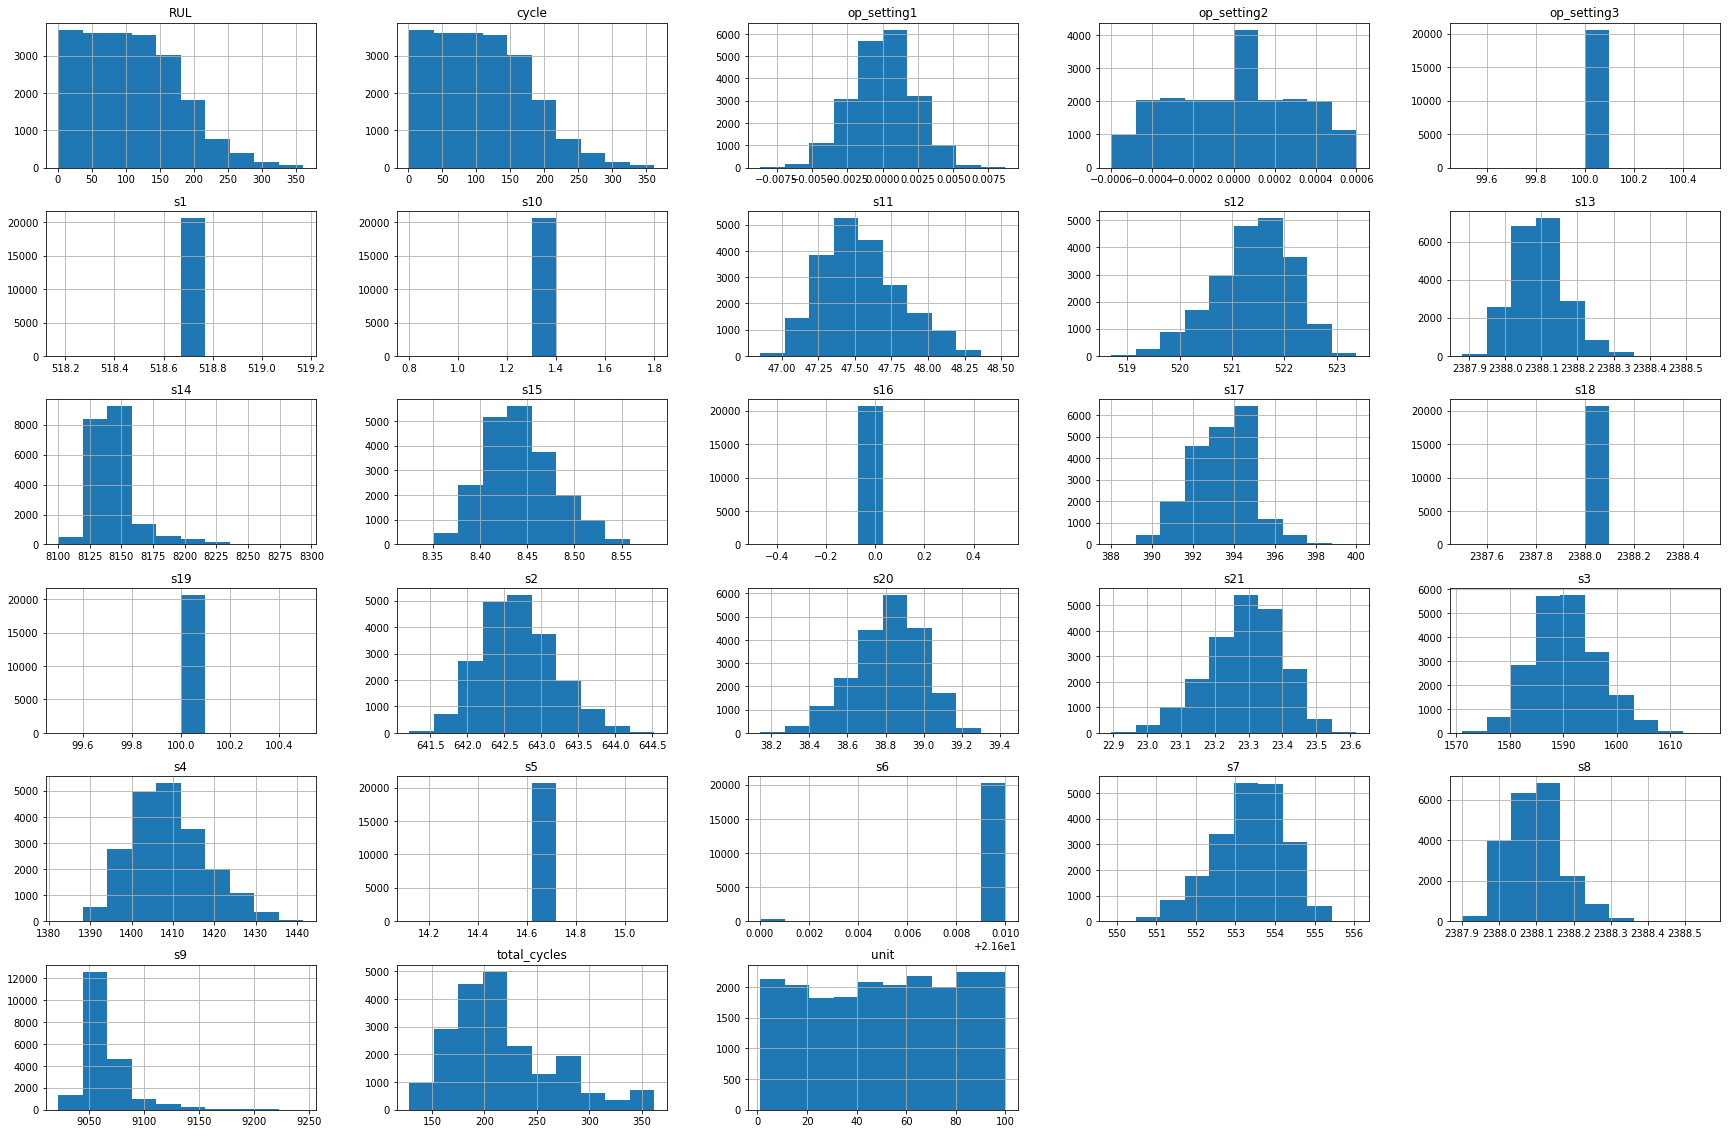

In [17]:

exp_data.hist(figsize = (30,20))
plt.show()

Next, we'll plot a correlation matrix. A correlation matrix illustrates correlation coefficients between sets of features. Each feature in the matrix is correlated with each of the other features in the matrix. This enables us to see which pairs have the highest correlation.

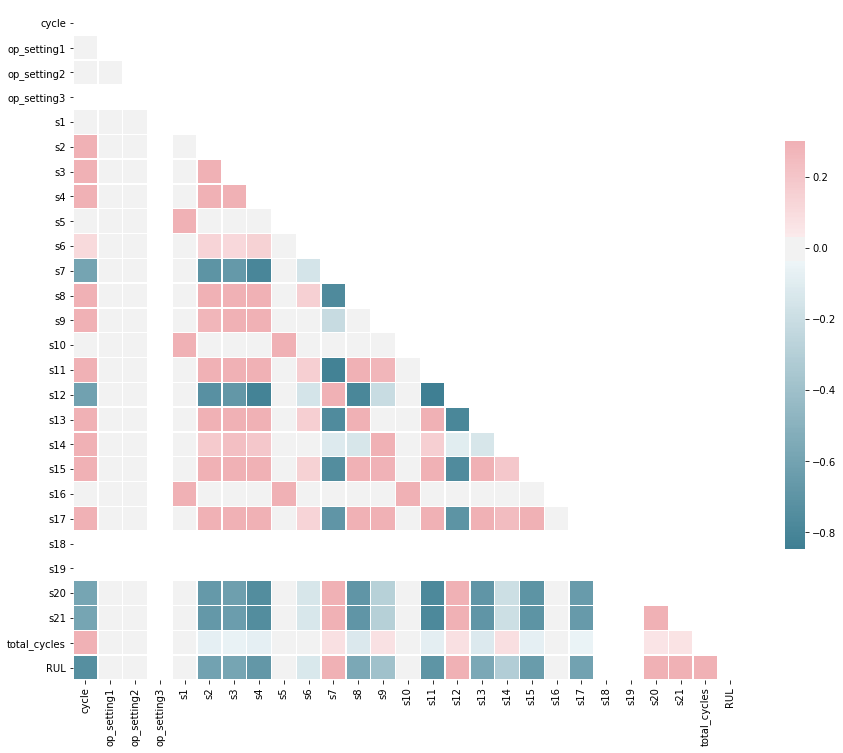

In [18]:
cov = exp_data.drop(columns=['unit',]).corr()
fig = plt.figure(figsize = (15,15))

mask = np.zeros_like(cov, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(cov, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The next step we will undertake is to examine how we can reduce the dimensions of the data set by by removing irrelevant or redundant features. The goal here is to find a minimum set of attributes such that the resulting probability distribution of the data classes is as close as possible to the original distribution obtained using all attributes. The algorithm we will employ is a random forest regressor.

The first step will be to normalize the data with the minmaxscaler. Normalization is done so that each attribute falls within the same range. This step helps ensure that attributes with large domains will not dominate attributes with smaller domains.

In [19]:
feature_data = exp_data.drop(['unit', 'cycle', 'total_cycles'], axis=1)

In [20]:
def select_feature(df):
   print("extract feature")

   # separate into input and output variables
   array = df.values
   X = df.drop('RUL',axis=1)
   y = df.RUL

   # Scale the data set
   scaler = MinMaxScaler(feature_range=(0, 1))
   x_transformed = scaler.fit_transform(X)

   # perform feature selection
   rfe = RFE(RandomForestRegressor(n_estimators=50, random_state=1), 4)
   fit = rfe.fit(X, y)

   # report selected features
   print('Selected Features:')
   names = df.columns.values[0:-1]
   for i in range(len(fit.support_)):
     if fit.support_[i]:
         print(names[i])

In [21]:
select_feature(feature_data)

extract feature
Selected Features:
s4
s9
s11
s12


Here, we can see that the most important features are s4, s9, s11, and s12.

#  Preprocessing the data

In the next stage, we will prepare the data for use in the regression models. We create a function (load_train_data) to prepare a training set using the Turbofan training data. We then prepare the test data using the function (load_test_data). We create another function (normalize) to remove attributes where the standard deviation is less than 0, as these have little or no predictive qualities.

In [22]:
def load_train_data(data_set):
    data = pd.read_csv(data_set, sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data 

In [23]:
def load_test_data(data_set):
    data = pd.read_csv(data_set, sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    
    RUL = pd.read_csv(streaming_body_6, sep = ' ', header = None)
    RUL = RUL[list(range(0, 1))]
    RUL['unit'] = list(range(1, len(RUL) + 1))
    RUL.rename(columns = {0 : 'RUL'}, inplace = True)
    
    data = data.merge(RUL, how = 'left', left_on = 'unit', right_on = 'unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis = 1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data

In [24]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    
    return (arr - mean) / std

In [25]:
def compute_score(RUL_real, RUL_pred):
   d = RUL_pred - RUL_real
   return np.sum(np.exp(d[d >= 0] / 10) - 1) + np.sum(np.exp(-1 * d[d < 0] / 13) - 1)

def MSE(RUL_real, RUL_pred):
   d = RUL_pred - RUL_real
   return np.sqrt(np.sum(d ** 2)) / len(d)

def MAE(RUL_real, RUL_pred):
    return np.mean(np.abs(RUL_pred - RUL_real))

## Loading the training and testing data

In [31]:
train_data = load_train_data(streaming_body_4)

In [35]:
test_data = load_test_data(streaming_body_5)

In [37]:
features = list(range(2, 26))

train_data[features] = train_data[features].apply(normalize, axis = 0)
test_data[features] = test_data[features].apply(normalize, axis = 0)

test_rows = test_data.groupby(['unit']).agg({'cycle' : max})
test_rows = test_rows.reset_index()
test_rows = test_rows.merge(test_data, how = 'left', left_on = ['unit', 'cycle'],
                                                    right_on = ['unit', 'cycle'])

In [38]:
y = train_data['RUL'].values

X_pred = test_rows[features].dropna(how = 'all', axis = 1)

X = train_data[features].dropna(how = 'all', axis = 1)

X = X.as_matrix()
X_pred = X_pred.as_matrix()

y_real = test_rows['RUL'].values

# Neural Network Regression

We train the model using a deep neural network regression algorithm called DNNRegressor, using TensorFlow. For more information about neural networks, see https://en.wikipedia.org/wiki/Neural_network. We set the hidden units to be 10, 15, and 10.

In [85]:
feature_columns = [tf.feature_column.numeric_column("x", shape = [17])]

regressor = tf.estimator.DNNRegressor(feature_columns = feature_columns,
                                      hidden_units    = [16, 31, 16])

train_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": X},
                                                    y = np.array(y, dtype = np.int),
                                                    num_epochs = None,
                                                    shuffle = True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": np.array(X_pred)},
                                                      num_epochs = 1,
                                                      shuffle = False)

regressor.train(input_fn = train_input_fn, steps = 100)
y_pred = regressor.predict(predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_session_config': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/home/dsxuser/.tmp/tmpl_76tjik', '_tf_random_seed': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /home/dsxuser/.tmp/tmpl_76tjik/model.ckpt.
INFO:tensorflow:loss = 2.0455e+06, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /home/dsxuser/.tmp/tmpl_76tjik/model.ckpt.
INFO:tensorflow:Loss for final step: 153457.0.


In [86]:
y_pred = [val for val in y_pred]
y_pred = np.array(list(map(lambda x: x['predictions'][0], y_pred)))

INFO:tensorflow:Restoring parameters from /home/dsxuser/.tmp/tmpl_76tjik/model.ckpt-100


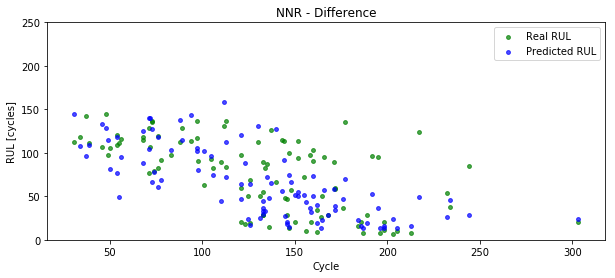

In [88]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))

axes.scatter(test_rows['cycle'], y_real, color = 'green', label = 'Real RUL', alpha = 0.7, s = 15)
axes.scatter(test_rows['cycle'], y_pred, color = 'blue', label = 'Predicted RUL', alpha = 0.7, s = 15)
axes.set_xlabel('Cycle')
axes.set_ylabel('RUL [cycles]')
axes.set_ylim([0, 250])
axes.set_title('NNR - Difference')



axes.legend()

plt.show()

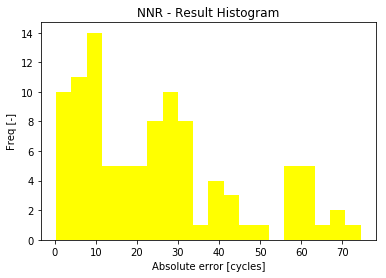

In [89]:
plt.hist(np.abs(y_real - y_pred), bins = 20, color='yellow')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('NNR - Result Histogram')
plt.show()

In [87]:
print('Average score per UUT:', compute_score(y_real, y_pred) / 100)
print('Mean squared Error:', MSE(y_real, y_pred))
print('Median difference:', np.median(np.abs(y_real - y_pred)))
print('R2 Score',  r2_score(y_real, y_pred))

Average score per UUT: 38.4940003879
Mean squared Error: 3.16507505206
Median difference: 22.8037147522
R2 Score 0.41989249882


# Kernel Ridge Regression

We will compare our neural network against a Kernel Ridge Regression model.

In [51]:
KRmodel = KernelRidge(alpha=1.0)
KRmodel.fit(X, y)
y_pred_kr = KRmodel.predict(X_pred)

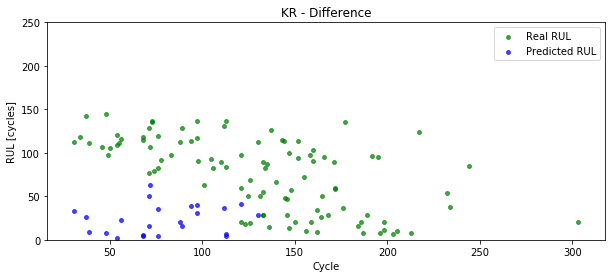

In [52]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))

axes.scatter(test_rows['cycle'], y_real, color = 'green', label = 'Real RUL', alpha = 0.7, s = 15)
axes.scatter(test_rows['cycle'], y_pred_kr, color = 'blue', label = 'Predicted RUL', alpha = 0.7, s = 15)
axes.set_xlabel('Cycle')
axes.set_ylabel('RUL [cycles]')
axes.set_ylim([0, 250])
axes.set_title('KR - Difference')

axes.legend()

plt.show()

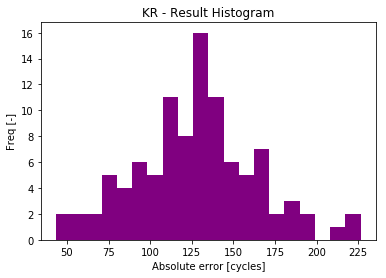

In [91]:
plt.hist(np.abs(y_real - y_pred_kr), bins = 20, color='purple')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('KR - Result Histogram')
plt.show()

In [92]:
print('Average score per UUT:', compute_score(y_real, y_pred_kr) / 100)
print('Mean squared Error:', MSE(y_real, y_pred_kr))
print('Median difference:', np.median(np.abs(y_real - y_pred_kr)))
print('R2 Score',  r2_score(y_real, y_pred_kr))

Average score per UUT: 869890.05872
Mean squared Error: 13.2596990912
Median difference: 128.841114882
R2 Score -9.18140686412


# Random Forest Regression
Finally we compare against Random Forest Regression

In [93]:
rfr = RandomForestRegressor()
rfr.fit(X, y)
y_pred_rfr = rfr.predict(X_pred)

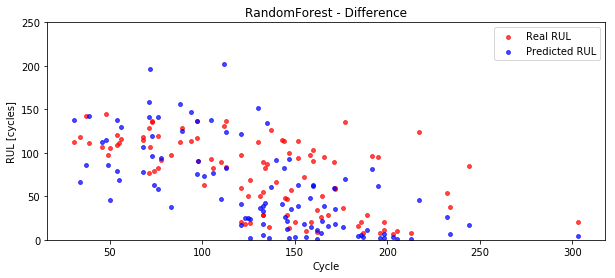

In [94]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))

axes.scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes.scatter(test_rows['cycle'], y_pred_rfr, color = 'blue', label = 'Predicted RUL', alpha = 0.7, s = 15)
axes.set_xlabel('Cycle')
axes.set_ylabel('RUL [cycles]')
axes.set_ylim([0, 250])
axes.set_title('RandomForest - Difference')


axes.legend()

plt.show()

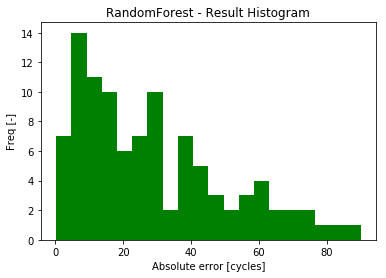

In [95]:
plt.hist(np.abs(y_real - y_pred_rfr), bins = 20, color='green')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('RandomForest - Result Histogram')
plt.show()

In [96]:
print('Average score per UUT:', compute_score(y_real, y_pred_rfr) / 100)
print('Mean squared Error:', MSE(y_real, y_pred_rfr))
print('Median difference:', np.median(np.abs(y_real - y_pred_rfr)))
print('R2 Score',  r2_score(y_real, y_pred_rfr))

Average score per UUT: 161.79509668
Mean squared Error: 3.58811231708
Median difference: 24.5
R2 Score 0.254457313974


# Conclusion

For evaluation purposes, we employed several techniques:

* R2. This is the coefficient of determination. It provides a measure of how well future samples are likely to be predicted by the model. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).  
* MSE. This is the mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss. Values closer to 0 are best.
* Median Difference. This is median of absolute differences between the real and predicted RULs
* Average Score. This is the overall score divided by the number of testing samples.

When we examine all three models, we can see that the Neural Network was the best, outperforming Kernel Ridge and Random Forest on all evaluations. Although the evaluation scores are not terrific, bear in mind that we did minimal data preprocessing and we did not tune the models. We would expect significant improvements were we to work with the data and the models more, but that is outside the scope of this notebook.

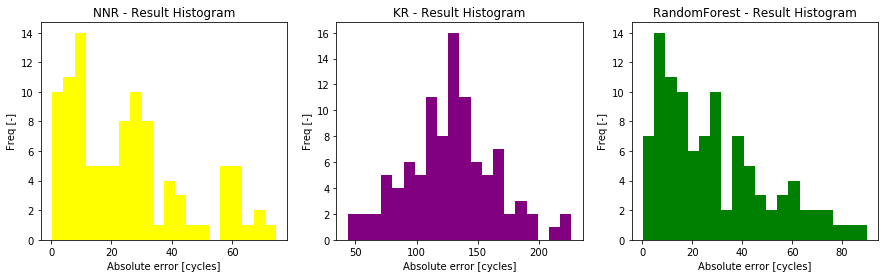

In [97]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
axes[0].hist(np.abs(y_real - y_pred), bins = 20, color='yellow')
axes[0].set_xlabel('Absolute error [cycles]')
axes[0].set_ylabel('Freq [-]')
axes[0].set_title('NNR - Result Histogram')

axes[1].hist(np.abs(y_real - y_pred_kr), bins = 20, color='purple')
axes[1].set_xlabel('Absolute error [cycles]')
axes[1].set_ylabel('Freq [-]')
axes[1].set_title('KR - Result Histogram')

axes[2].hist(np.abs(y_real - y_pred_rfr), bins = 20, color='green')
axes[2].set_xlabel('Absolute error [cycles]')
axes[2].set_ylabel('Freq [-]')
axes[2].set_title('RandomForest - Result Histogram')

plt.show()

| Evaluator         | Neural Network| Kernel Ridge| Random Forest|
| ----------------- |:-------------:|:-----------:|-------------:|
| Average Score     | 38.49         | 869890.06      |161.80         |
| MSE               | 3.17          | 13.25        |3.59         |
| Median Difference | 22.8         | 128.84       |24.5        |
| R2 Score          | 0.42          | -9.18        |0.25         |

Hopefully, this notebook has give you a sense of the various steps one might take in a regression modelling excercise. Finding the best fit for the problem you are trying to solve is iterative and experimental.

Now that you have found a good model for this type of regression, think about how you might use this in a production setting with Maximo Predictive Maintenance Insights (PMI). For example, in addition to viewing it in Maximo PMI, you might also want to create some automation scripts to trigger service requests or even work orders when a predicted RUL is closer than expected.